In [26]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets,transforms
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

In [27]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [28]:
DATA_DIR = "data/trainingSet"

In [29]:
PROCESS_DATA = 1
TRAINING_DATA = 1

In [30]:
IMG_SIZE = 64
BATCH_SIZE = 64
LATENT_SIZE = 100

In [31]:
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [32]:
if PROCESS_DATA:
    dataset = datasets.ImageFolder(DATA_DIR, transform= data_transform)
    dataloader = data.DataLoader(dataset,batch_size=BATCH_SIZE, num_workers=4, shuffle=True)

In [33]:
#Show data size
print(len(dataset))

7437


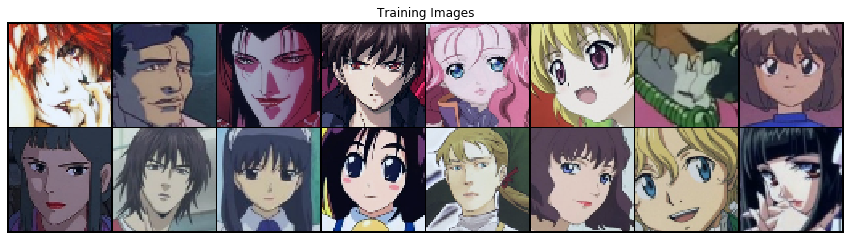

In [34]:
#Visualize some training data
def visualize_data(dataloader, NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(15,15))
    img = next(iter(dataloader))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(img[0][a:a+NUM_PIC],padding=1, normalize=True),(1,2,0)))
    plt.show()

visualize_data(dataloader)

In [35]:
#Make random latent noise vector
def random_noise(size):
    noise = torch.randn(size, LATENT_SIZE, 1 , 1)
    return Variable(noise).to(device)

In [36]:
#Generate truth or false label
def generate_label(size,label):
    if label:
        data = torch.ones(size,1) - 0.1 #Smooth label one-side
    else:
        data = torch.zeros(size,1)
    return Variable(data).view(-1).to(device)

In [37]:
#Inititate weights for Generator and Discriminator with mean = 0.02, standard deviation = 1
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [38]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128*8,4,1,0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*8,128*4,4,2,1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*4,128*2,4,2,1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*2,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,3,4,2,1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [39]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*2, 128*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*4, 128*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [40]:
#Train the discriminator
def train_discriminator(D, D_optimizer, error, real_data, fake_data):
    batch_size = real_data.size(0)
    D_optimizer.zero_grad()
    
    #Training on all real data
    real_data = real_data.to(device)
    predict_real = D(real_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss_real = error(predict_real,real_label)
    loss_real.backward()
    
    
    #Training on all fake data
    fake_data = fake_data.to(device)
    predict_fake = D(fake_data).view(-1)
    fake_label = generate_label(batch_size, 0)
    loss_fake = error(predict_fake, fake_label)
    loss_fake.backward()
    
    D_x = predict_real.mean().item()
    D_g_z1 = predict_fake.mean().item()
    
    D_optimizer.step()
    
    return loss_real.data+loss_fake.data, D_x, D_g_z1
    

In [41]:
#Train the generator
def train_generator(D, G_optimizer, error, fake_data):
    batch_size = fake_data.size(0)
    G_optimizer.zero_grad()
    fake_data = fake_data.to(device)
    predict = D(fake_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss = error(predict, real_label)
    loss.backward()
    G_optimizer.step()
    D_g_z2 = predict.mean().item()
    return loss.data, D_g_z2

In [42]:
#Generate some samples
def generate_samples(G, noise):
    G.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(15,10))
        generated = G(noise).view(-1,3,IMG_SIZE,IMG_SIZE).data.cpu()
        img = np.transpose(torchvision.utils.make_grid(generated[:],padding =1, normalize=True),(1,2,0))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()
    G.train()

In [43]:
#Generate fixed test noise
test_noise = random_noise(16)

In [44]:
#Start training process
def train(D, G, D_optimizer, G_optimizer, error, dataloader):
    EPOCHS = 50
    D_loss_list = []
    G_loss_list = []
    print("Start Training.....")
    for epoch in range(EPOCHS):
        for i, (real_batch,_) in enumerate(dataloader):
            #First train the Discriminator
            batch_size = real_batch.size(0)
            real_data = Variable(real_batch.view(-1,3,IMG_SIZE,IMG_SIZE))
            fake_data = G(random_noise(batch_size)).detach()
            D_loss, D_x, D_g_z1 = train_discriminator(D, D_optimizer, error, real_data, fake_data)
            
            #Then train the Generator
            data = G(random_noise(batch_size))
            G_loss, D_g_z2 = train_generator(D, G_optimizer, error, data)
            
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)
            
            if i%50==0:
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch+1,EPOCHS,i,len(dataloader),D_loss,G_loss,D_x, D_g_z1,D_g_z2))
        torch.save(G.state_dict(), "model/generator.pth")
        torch.save(D.state_dict(), "model/discriminator.pth")
        if epoch%5==0:
            generate_samples(G, test_noise)
    print("Training Completed!")
    return G, D_loss_list, G_loss_list

Start Training.....
Epoch: (0/50), Batch: (0/117), D_Loss: 1.4170, G_Loss: 4.4230, D(x): 0.4380, G(D(z)): 0.2120 / 0.0207
Epoch: (0/50), Batch: (50/117), D_Loss: 1.2909, G_Loss: 36.3227, D(x): 0.9807, G(D(z)): 0.0000 / 0.0000
Epoch: (0/50), Batch: (100/117), D_Loss: 0.4511, G_Loss: 61.3910, D(x): 0.8324, G(D(z)): 0.0000 / 0.0000


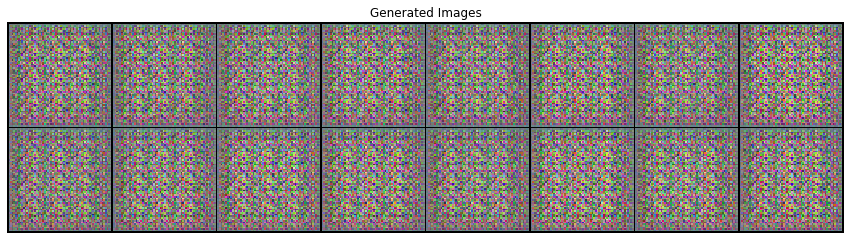

Epoch: (1/50), Batch: (0/117), D_Loss: 0.4682, G_Loss: 60.1106, D(x): 0.7354, G(D(z)): 0.0000 / 0.0000
Epoch: (1/50), Batch: (50/117), D_Loss: 0.4057, G_Loss: 58.3635, D(x): 0.9458, G(D(z)): 0.0000 / 0.0000
Epoch: (1/50), Batch: (100/117), D_Loss: 0.3798, G_Loss: 56.8789, D(x): 0.8481, G(D(z)): 0.0000 / 0.0000
Epoch: (2/50), Batch: (0/117), D_Loss: 0.3446, G_Loss: 57.1375, D(x): 0.8650, G(D(z)): 0.0000 / 0.0000
Epoch: (2/50), Batch: (50/117), D_Loss: 0.5935, G_Loss: 54.9691, D(x): 0.9840, G(D(z)): 0.0000 / 0.0000
Epoch: (2/50), Batch: (100/117), D_Loss: 0.3355, G_Loss: 54.5795, D(x): 0.9082, G(D(z)): 0.0000 / 0.0000
Epoch: (3/50), Batch: (0/117), D_Loss: 0.3426, G_Loss: 54.5584, D(x): 0.9337, G(D(z)): 0.0000 / 0.0000
Epoch: (3/50), Batch: (50/117), D_Loss: 0.3338, G_Loss: 53.8914, D(x): 0.8799, G(D(z)): 0.0000 / 0.0000
Epoch: (3/50), Batch: (100/117), D_Loss: 0.3336, G_Loss: 53.4410, D(x): 0.8708, G(D(z)): 0.0000 / 0.0000
Epoch: (4/50), Batch: (0/117), D_Loss: 0.3342, G_Loss: 53.0160, 

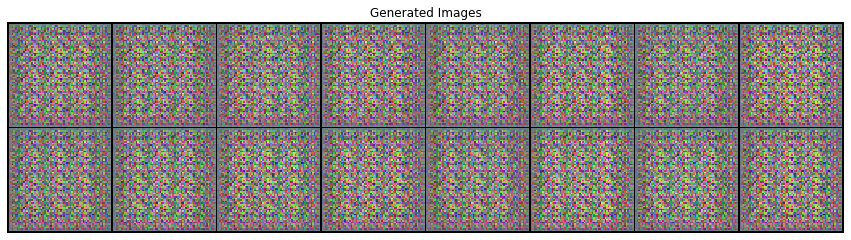

Epoch: (6/50), Batch: (0/117), D_Loss: 0.3283, G_Loss: 51.5256, D(x): 0.9100, G(D(z)): 0.0000 / 0.0000
Epoch: (6/50), Batch: (50/117), D_Loss: 0.3360, G_Loss: 51.0334, D(x): 0.9256, G(D(z)): 0.0000 / 0.0000
Epoch: (6/50), Batch: (100/117), D_Loss: 0.3360, G_Loss: 51.2227, D(x): 0.9168, G(D(z)): 0.0000 / 0.0000
Epoch: (7/50), Batch: (0/117), D_Loss: 0.3335, G_Loss: 50.5124, D(x): 0.9176, G(D(z)): 0.0000 / 0.0000
Epoch: (7/50), Batch: (50/117), D_Loss: 0.3382, G_Loss: 49.3703, D(x): 0.8773, G(D(z)): 0.0000 / 0.0000
Epoch: (7/50), Batch: (100/117), D_Loss: 0.3904, G_Loss: 49.0673, D(x): 0.9508, G(D(z)): 0.0000 / 0.0000
Epoch: (8/50), Batch: (0/117), D_Loss: 0.3272, G_Loss: 49.0885, D(x): 0.9009, G(D(z)): 0.0000 / 0.0000
Epoch: (8/50), Batch: (50/117), D_Loss: 0.3281, G_Loss: 48.8082, D(x): 0.8833, G(D(z)): 0.0000 / 0.0000
Epoch: (8/50), Batch: (100/117), D_Loss: 0.3264, G_Loss: 48.4899, D(x): 0.8951, G(D(z)): 0.0000 / 0.0000
Epoch: (9/50), Batch: (0/117), D_Loss: 0.3380, G_Loss: 48.0295, 

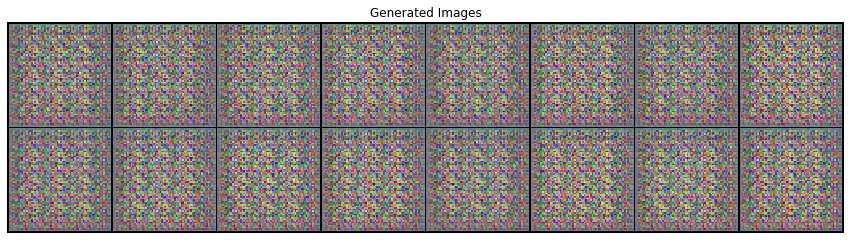

Epoch: (11/50), Batch: (0/117), D_Loss: 0.3296, G_Loss: 46.5696, D(x): 0.8871, G(D(z)): 0.0000 / 0.0000
Epoch: (11/50), Batch: (50/117), D_Loss: 0.4477, G_Loss: 45.1252, D(x): 0.9629, G(D(z)): 0.0000 / 0.0000
Epoch: (11/50), Batch: (100/117), D_Loss: 0.3322, G_Loss: 45.7499, D(x): 0.9131, G(D(z)): 0.0000 / 0.0000
Epoch: (12/50), Batch: (0/117), D_Loss: 0.3297, G_Loss: 45.2572, D(x): 0.8864, G(D(z)): 0.0000 / 0.0000
Epoch: (12/50), Batch: (50/117), D_Loss: 0.3273, G_Loss: 45.4312, D(x): 0.8967, G(D(z)): 0.0000 / 0.0000
Epoch: (12/50), Batch: (100/117), D_Loss: 0.3272, G_Loss: 45.2433, D(x): 0.9144, G(D(z)): 0.0000 / 0.0000
Epoch: (13/50), Batch: (0/117), D_Loss: 0.3302, G_Loss: 44.9619, D(x): 0.8875, G(D(z)): 0.0000 / 0.0000
Epoch: (13/50), Batch: (50/117), D_Loss: 0.3291, G_Loss: 44.4182, D(x): 0.8873, G(D(z)): 0.0000 / 0.0000
Epoch: (13/50), Batch: (100/117), D_Loss: 0.3272, G_Loss: 44.2236, D(x): 0.9139, G(D(z)): 0.0000 / 0.0000
Epoch: (14/50), Batch: (0/117), D_Loss: 0.3307, G_Loss:

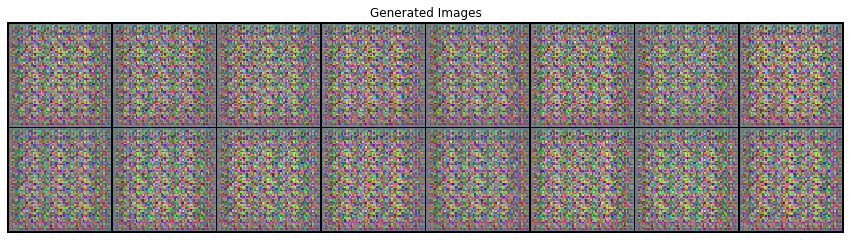

Epoch: (16/50), Batch: (0/117), D_Loss: 0.3331, G_Loss: 43.0672, D(x): 0.9067, G(D(z)): 0.0000 / 0.0000
Epoch: (16/50), Batch: (50/117), D_Loss: 0.3291, G_Loss: 42.8350, D(x): 0.9146, G(D(z)): 0.0000 / 0.0000
Epoch: (16/50), Batch: (100/117), D_Loss: 0.3379, G_Loss: 42.5319, D(x): 0.9089, G(D(z)): 0.0000 / 0.0000
Epoch: (17/50), Batch: (0/117), D_Loss: 0.3377, G_Loss: 42.0074, D(x): 0.8579, G(D(z)): 0.0000 / 0.0000
Epoch: (17/50), Batch: (50/117), D_Loss: 0.3261, G_Loss: 41.7553, D(x): 0.8928, G(D(z)): 0.0000 / 0.0000
Epoch: (17/50), Batch: (100/117), D_Loss: 0.3258, G_Loss: 41.6318, D(x): 0.8950, G(D(z)): 0.0000 / 0.0000
Epoch: (18/50), Batch: (0/117), D_Loss: 0.3300, G_Loss: 41.5509, D(x): 0.9114, G(D(z)): 0.0000 / 0.0000
Epoch: (18/50), Batch: (50/117), D_Loss: 0.3279, G_Loss: 40.9385, D(x): 0.8827, G(D(z)): 0.0000 / 0.0000
Epoch: (18/50), Batch: (100/117), D_Loss: 0.3633, G_Loss: 41.0950, D(x): 0.9205, G(D(z)): 0.0000 / 0.0000
Epoch: (19/50), Batch: (0/117), D_Loss: 0.3715, G_Loss:

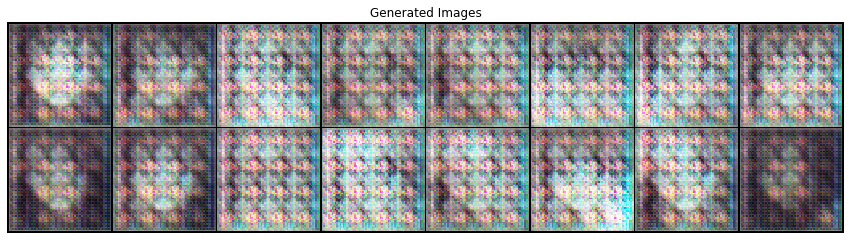

Epoch: (21/50), Batch: (0/117), D_Loss: 1.3144, G_Loss: 4.6745, D(x): 0.8785, G(D(z)): 0.5428 / 0.0101
Epoch: (21/50), Batch: (50/117), D_Loss: 0.9312, G_Loss: 2.1725, D(x): 0.8092, G(D(z)): 0.3387 / 0.1149
Epoch: (21/50), Batch: (100/117), D_Loss: 1.2519, G_Loss: 3.3160, D(x): 0.7759, G(D(z)): 0.4600 / 0.0431
Epoch: (22/50), Batch: (0/117), D_Loss: 1.1932, G_Loss: 5.2038, D(x): 0.6634, G(D(z)): 0.3635 / 0.0243
Epoch: (22/50), Batch: (50/117), D_Loss: 0.8662, G_Loss: 3.2403, D(x): 0.5641, G(D(z)): 0.0544 / 0.0540
Epoch: (22/50), Batch: (100/117), D_Loss: 0.8753, G_Loss: 3.1977, D(x): 0.7295, G(D(z)): 0.2883 / 0.0491
Epoch: (23/50), Batch: (0/117), D_Loss: 1.1690, G_Loss: 2.2547, D(x): 0.4762, G(D(z)): 0.1011 / 0.1537
Epoch: (23/50), Batch: (50/117), D_Loss: 1.2083, G_Loss: 3.6727, D(x): 0.6040, G(D(z)): 0.3479 / 0.0283
Epoch: (23/50), Batch: (100/117), D_Loss: 0.8755, G_Loss: 4.2237, D(x): 0.7778, G(D(z)): 0.3039 / 0.0143
Epoch: (24/50), Batch: (0/117), D_Loss: 1.0623, G_Loss: 1.6204, 

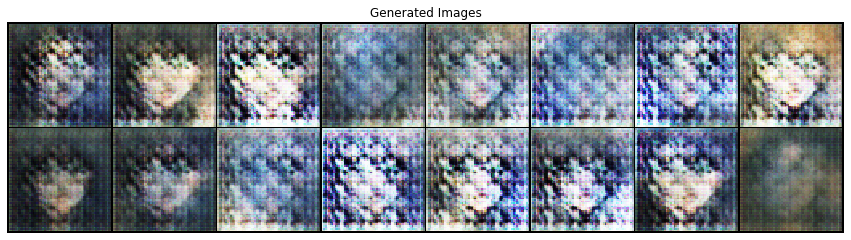

Epoch: (26/50), Batch: (0/117), D_Loss: 1.1923, G_Loss: 4.0382, D(x): 0.8754, G(D(z)): 0.4759 / 0.0300
Epoch: (26/50), Batch: (50/117), D_Loss: 1.4811, G_Loss: 3.1160, D(x): 0.2963, G(D(z)): 0.0183 / 0.0434
Epoch: (26/50), Batch: (100/117), D_Loss: 0.8900, G_Loss: 3.5211, D(x): 0.6955, G(D(z)): 0.2571 / 0.0383
Epoch: (27/50), Batch: (0/117), D_Loss: 1.2902, G_Loss: 2.5667, D(x): 0.5701, G(D(z)): 0.3417 / 0.0922
Epoch: (27/50), Batch: (50/117), D_Loss: 1.1846, G_Loss: 2.1143, D(x): 0.4589, G(D(z)): 0.1488 / 0.1308
Epoch: (27/50), Batch: (100/117), D_Loss: 1.0233, G_Loss: 2.7669, D(x): 0.7011, G(D(z)): 0.3400 / 0.0671
Epoch: (28/50), Batch: (0/117), D_Loss: 2.1190, G_Loss: 5.6440, D(x): 0.9089, G(D(z)): 0.7243 / 0.0052
Epoch: (28/50), Batch: (50/117), D_Loss: 1.1658, G_Loss: 3.7213, D(x): 0.8059, G(D(z)): 0.4528 / 0.0292
Epoch: (28/50), Batch: (100/117), D_Loss: 0.8861, G_Loss: 3.5508, D(x): 0.7043, G(D(z)): 0.2726 / 0.0316
Epoch: (29/50), Batch: (0/117), D_Loss: 1.2529, G_Loss: 5.4918, 

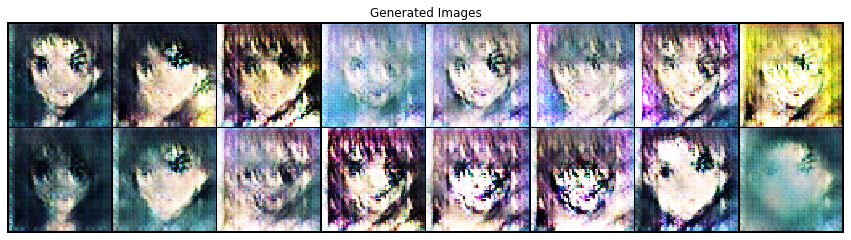

Epoch: (31/50), Batch: (0/117), D_Loss: 0.9634, G_Loss: 3.9933, D(x): 0.7924, G(D(z)): 0.3469 / 0.0216
Epoch: (31/50), Batch: (50/117), D_Loss: 1.2039, G_Loss: 3.2825, D(x): 0.8602, G(D(z)): 0.4437 / 0.0492
Epoch: (31/50), Batch: (100/117), D_Loss: 1.6106, G_Loss: 7.8883, D(x): 0.9032, G(D(z)): 0.6615 / 0.0009
Epoch: (32/50), Batch: (0/117), D_Loss: 0.9045, G_Loss: 1.8303, D(x): 0.5390, G(D(z)): 0.1168 / 0.1732
Epoch: (32/50), Batch: (50/117), D_Loss: 0.8890, G_Loss: 2.0376, D(x): 0.5076, G(D(z)): 0.0580 / 0.1489
Epoch: (32/50), Batch: (100/117), D_Loss: 1.4644, G_Loss: 3.1702, D(x): 0.3336, G(D(z)): 0.0076 / 0.0750
Epoch: (33/50), Batch: (0/117), D_Loss: 0.7160, G_Loss: 3.0230, D(x): 0.6083, G(D(z)): 0.0425 / 0.0616
Epoch: (33/50), Batch: (50/117), D_Loss: 0.6870, G_Loss: 2.7688, D(x): 0.7286, G(D(z)): 0.1734 / 0.0647
Epoch: (33/50), Batch: (100/117), D_Loss: 0.7629, G_Loss: 3.2829, D(x): 0.6163, G(D(z)): 0.0716 / 0.0488
Epoch: (34/50), Batch: (0/117), D_Loss: 1.6310, G_Loss: 4.9524, 

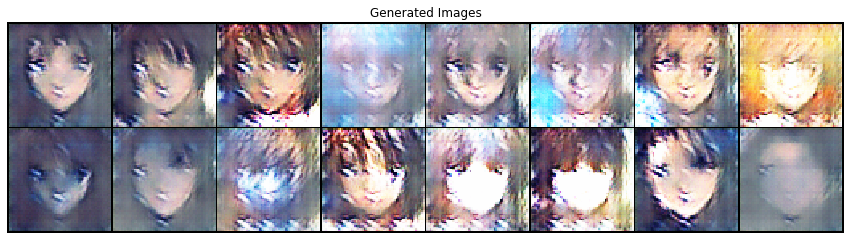

Epoch: (36/50), Batch: (0/117), D_Loss: 0.7420, G_Loss: 4.6786, D(x): 0.8252, G(D(z)): 0.2536 / 0.0089
Epoch: (36/50), Batch: (50/117), D_Loss: 1.2508, G_Loss: 6.0260, D(x): 0.9100, G(D(z)): 0.5180 / 0.0044
Epoch: (36/50), Batch: (100/117), D_Loss: 0.6179, G_Loss: 3.1247, D(x): 0.7208, G(D(z)): 0.0803 / 0.0416
Epoch: (37/50), Batch: (0/117), D_Loss: 0.7358, G_Loss: 3.8785, D(x): 0.7318, G(D(z)): 0.1620 / 0.0343
Epoch: (37/50), Batch: (50/117), D_Loss: 0.5185, G_Loss: 3.9150, D(x): 0.8831, G(D(z)): 0.1104 / 0.0232
Epoch: (37/50), Batch: (100/117), D_Loss: 0.7306, G_Loss: 3.3721, D(x): 0.5897, G(D(z)): 0.0326 / 0.0657
Epoch: (38/50), Batch: (0/117), D_Loss: 0.9915, G_Loss: 6.5441, D(x): 0.9323, G(D(z)): 0.4083 / 0.0014
Epoch: (38/50), Batch: (50/117), D_Loss: 0.7271, G_Loss: 2.7435, D(x): 0.6131, G(D(z)): 0.0487 / 0.0686
Epoch: (38/50), Batch: (100/117), D_Loss: 0.8460, G_Loss: 5.5351, D(x): 0.9465, G(D(z)): 0.3017 / 0.0063
Epoch: (39/50), Batch: (0/117), D_Loss: 0.8171, G_Loss: 4.7351, 

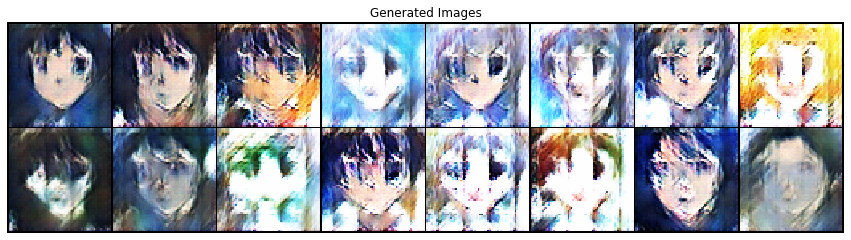

Epoch: (41/50), Batch: (0/117), D_Loss: 0.4658, G_Loss: 4.5958, D(x): 0.7833, G(D(z)): 0.0296 / 0.0102
Epoch: (41/50), Batch: (50/117), D_Loss: 1.0066, G_Loss: 5.9794, D(x): 0.9330, G(D(z)): 0.3894 / 0.0031
Epoch: (41/50), Batch: (100/117), D_Loss: 0.8432, G_Loss: 5.0073, D(x): 0.9179, G(D(z)): 0.3020 / 0.0102
Epoch: (42/50), Batch: (0/117), D_Loss: 0.6757, G_Loss: 5.7681, D(x): 0.8995, G(D(z)): 0.2238 / 0.0057
Epoch: (42/50), Batch: (50/117), D_Loss: 1.5318, G_Loss: 1.9407, D(x): 0.2581, G(D(z)): 0.0067 / 0.1899
Epoch: (42/50), Batch: (100/117), D_Loss: 0.9331, G_Loss: 2.1569, D(x): 0.4671, G(D(z)): 0.0341 / 0.1851
Epoch: (43/50), Batch: (0/117), D_Loss: 0.6824, G_Loss: 3.6407, D(x): 0.6781, G(D(z)): 0.0813 / 0.0302
Epoch: (43/50), Batch: (50/117), D_Loss: 0.7446, G_Loss: 3.9354, D(x): 0.5874, G(D(z)): 0.0101 / 0.0236
Epoch: (43/50), Batch: (100/117), D_Loss: 0.6440, G_Loss: 4.1770, D(x): 0.9187, G(D(z)): 0.1873 / 0.0207
Epoch: (44/50), Batch: (0/117), D_Loss: 0.8709, G_Loss: 5.5180, 

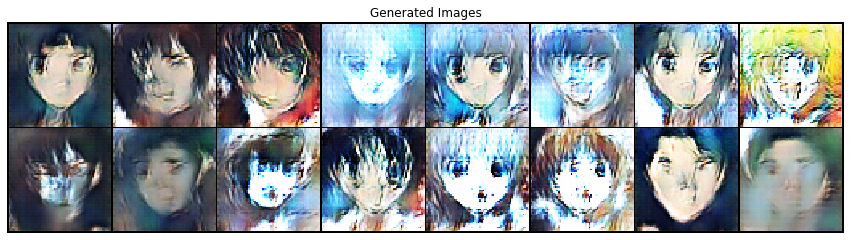

Epoch: (46/50), Batch: (0/117), D_Loss: 1.1063, G_Loss: 2.0133, D(x): 0.4128, G(D(z)): 0.0161 / 0.1664
Epoch: (46/50), Batch: (50/117), D_Loss: 0.4836, G_Loss: 3.5815, D(x): 0.7660, G(D(z)): 0.0400 / 0.0350
Epoch: (46/50), Batch: (100/117), D_Loss: 0.8044, G_Loss: 1.5807, D(x): 0.5683, G(D(z)): 0.0500 / 0.2447
Epoch: (47/50), Batch: (0/117), D_Loss: 0.8302, G_Loss: 1.8220, D(x): 0.5288, G(D(z)): 0.0397 / 0.2038
Epoch: (47/50), Batch: (50/117), D_Loss: 0.6013, G_Loss: 3.9359, D(x): 0.6638, G(D(z)): 0.0240 / 0.0242
Epoch: (47/50), Batch: (100/117), D_Loss: 0.5177, G_Loss: 3.1382, D(x): 0.7530, G(D(z)): 0.0540 / 0.0645
Epoch: (48/50), Batch: (0/117), D_Loss: 0.8358, G_Loss: 7.8257, D(x): 0.9645, G(D(z)): 0.2723 / 0.0008
Epoch: (48/50), Batch: (50/117), D_Loss: 0.4637, G_Loss: 3.9324, D(x): 0.7689, G(D(z)): 0.0336 / 0.0238
Epoch: (48/50), Batch: (100/117), D_Loss: 0.5706, G_Loss: 2.6192, D(x): 0.7752, G(D(z)): 0.0648 / 0.0984
Epoch: (49/50), Batch: (0/117), D_Loss: 0.5991, G_Loss: 5.1498, 

In [45]:
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(weights_init)
G.apply(weights_init)

if TRAINING_DATA:
    D_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas= (0.5, 0.999))
    G_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    error = nn.BCELoss()
    G, D_loss_list, G_loss_list = train(D, G, D_optimizer, G_optimizer, error, dataloader)
else:
    G.load_state_dict(torch.load("model/generator.pth"))

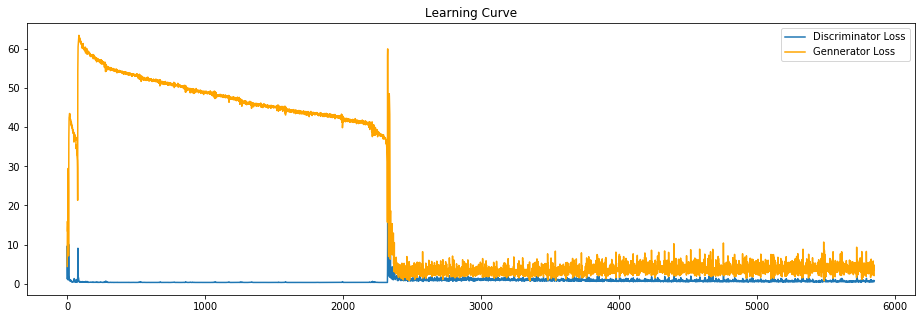

In [46]:
#Plot learning curves
def plot(D_loss_list, G_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_loss_list)
    fig = plt.figure(figsize=(35,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS), D_loss_list,label = "Discriminator Loss")
    plt.plot(range(EPOCHS),G_loss_list, color ="orange",label = "Gennerator Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
    
plot(D_loss_list, G_loss_list)

In [1]:
#Generate final samples
def visualize_final(NUM_PIC=16):
    test_noise = random_noise(NUM_PIC)
    generate_samples(G, test_noise)
visualize_final()

NameError: name 'random_noise' is not defined